Following notes from John Boland, creating a clear sky model model using Fourier analysis

### Load packages and data

In [35]:
import datetime as dt
import ephem
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.dates as mdates
import numpy as np
import os
import pandas as pd
import scipy
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf

from tqdm import tqdm_notebook

Change these years as required.

In [2]:
# Change these years as required.
from_year = 2010
to_year = 2017

year_range = range(from_year,to_year+1)

In [3]:
colspec = [(0,2), (3,9), (10,14), (15,17), (18,20), (21,23), (24,26), 
           (27,34), (35,42), (43,50), (51,58), (59,66), 
           (67,74), (75,82), (83,90), (91,98), (99,106), 
           (107,114), (115,122), (123,130), (131,138), (139,146), 
           (147,154), (155,162), (163,170), (171,178), (179,186), 
           (187,194), (195,202), (203,210), (211, 218), (219,226), 
           (227,232), (233,238), (239,244), (245,252)]

headers = ['record_id', 'station_number', 'yr', 'mth', 'day', 'hr', 'mnt', 
          'mean_global', 'min_global', 'max_global', 'sd_global', 'uncert_mean_global',
          'mean_direct', 'min_direct', 'max_direct', 'sd_direct', 'uncert_mean_direct',
          'mean_diffuse', 'min_diffuse', 'max_diffuse', 'sd_diffuse', 'uncert_mean_diffuse',
          'mean_terr', 'min_terr', 'max_terr', 'sd_terr', 'uncert_mean_terr',
          'mean_dir_horiz', 'min_dir_horiz', 'max_dir_horiz', 'sd_dir_horiz', 'uncert_dir_horiz',
          'sunsh_sec_96', 'sunsh_sec_120', 'sunsh_sec_144', 'zenith_dist']

In [4]:
from collections import defaultdict

yr_dict = defaultdict(list)

for yr in tqdm_notebook(year_range):
    files = os.listdir(f'E:/Adelaide/{yr}/')
    yr_dict[yr] = pd.DataFrame()
    for f in tqdm_notebook(files):
        df = pd.read_fwf(os.path.join(f'E:/Adelaide/{yr}/', f), 
                         colspecs=colspec, names=headers, index_col=False, skiprows=[0],
                         parse_dates=[['yr','mth', 'day', 'hr', 'mnt']],
                         date_parser=lambda yyyy, mm, dd, HH, MM: pd.to_datetime(
                             (yyyy+mm+dd+HH+MM), format='%Y%m%d%H%M'))
        yr_dict[yr] = yr_dict[yr].append(df)
    yr_dict[yr].set_index('yr_mth_day_hr_mnt', drop=True, inplace=True)
    yr_dict[yr].index.name = 'date_time' 
    yr_dict[yr].sort_index(ascending=True, inplace=True)
    

In [5]:
yr_dict[2010].to_csv(os.path.join('..\\Relevant data\\Capstone\\solar\\', f'PV_{2010:4n}.csv'), sep=',')

In [16]:
for yr in tqdm_notebook(yr_dict.keys()):
    yr_dict[yr].to_csv(os.path.join('..\\Relevant data\\Capstone\\solar\\', f'PV_{yr:4n}.csv'), sep=',')

The solar data was previously consolidated from monthly files into yearly files.  Here, the years are each loaded as values in a dictionary.

In [18]:
PV = {}

for year in tqdm_notebook(year_range):
    try:
        PV[str(year)] = pd.read_csv(
                '..\\Relevant data\\Capstone\\solar\\PV_' + str(year) + '.csv',
                parse_dates=['date_time'],
                index_col='date_time')
    except:
        pass

In [19]:
# Years for which (some) data is present
yrs = PV.keys()
yrs

dict_keys(['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])

### Data investigation and transformation

In [20]:
# Merge into a single dataframe
PV = pd.concat(PV.values())
PV.head()

,record_id,station_number,mean_global,min_global,max_global,sd_global,uncert_mean_global,mean_direct,min_direct,max_direct,...,uncert_mean_terr,mean_dir_horiz,min_dir_horiz,max_dir_horiz,sd_dir_horiz,uncert_dir_horiz,sunsh_sec_96,sunsh_sec_120,sunsh_sec_144,zenith_dist
date_time,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,sl,23034,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,...,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
2010-01-01 00:01:00,sl,23034,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,...,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
2010-01-01 00:02:00,sl,23034,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,...,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
2010-01-01 00:03:00,sl,23034,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,...,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
2010-01-01 00:04:00,sl,23034,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,...,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0


In [21]:
# Drop unused columns
use_cols = ['mean_dir_horiz','mean_diffuse','zenith_dist']
PV = PV[use_cols]

In [22]:
PV.head()

,mean_dir_horiz,mean_diffuse,zenith_dist
date_time,,,
2010-01-01 00:00:00,0.0,0.0,0.0
2010-01-01 00:01:00,0.0,0.0,0.0
2010-01-01 00:02:00,0.0,0.0,0.0
2010-01-01 00:03:00,0.0,0.0,0.0
2010-01-01 00:04:00,0.0,0.0,0.0


In [23]:
# Create Global Horizontal Irradiance ('GHI') variable
PV['GHI'] = PV['mean_dir_horiz'] + PV['mean_diffuse']

In [24]:
# Check for missing data (where there is a timestamp but no measurement of mean_dir_horiz, mean_diffuse, zenith_dist or GHI).
np.isnan(PV).sum()

mean_dir_horiz    61137
mean_diffuse      51800
zenith_dist       44012
GHI               64528
dtype: int64

In [32]:
# Check for duplicate timestamps
PV.index.duplicated().sum()

0

In [26]:
# How many minutes should there be if there are continuous minute timestamps
# between the first and last timestamps in the series?
def expected_minutes(ts):
    return(int((ts.iloc[-1].name - ts.iloc[0].name).total_seconds() / 60 + 1))
expected_minutes(PV)

4207680

In [27]:
# How many timestamps are there actually in the datasets?
len(PV)

4142880

In [28]:
# How many timestamps are missing throughout each year
expected_minutes(PV) - len(PV)

64800

In [29]:
# Resample using the same frequency to ensure continuous time series
PV = PV.resample('T').mean()

In [30]:
# Check again for missing timestamps
expected_minutes(PV) - len(PV)

0

In [31]:
# Create variables for grouping data
PV['year'] = PV.index.year
PV['month_day'] = list(zip(PV.index.month,PV.index.day))
PV['time_of_day'] = PV.index.time

### Experiments with `ephem` package

Get list of previous winter solstices corresponding to each year in the dataset

In [37]:
last_solstice = [str(ephem.previous_solstice(yr)) for yr in yrs]
last_solstice = [dt.datetime.strptime(i,'%Y/%m/%d %H:%M:%S') for i in last_solstice]

In [38]:
tropical_yr_lengths = [i - j for i, j in zip(last_solstice[1:], last_solstice[:-1])]

for year in tqdm_notebook(tropical_yr_lengths):
    print(year)

365 days, 5:51:40
365 days, 5:51:35
365 days, 5:41:35
365 days, 5:59:24
365 days, 5:51:59
365 days, 5:44:57
365 days, 5:56:13



Could these be used to better align minutes of each day with the seasons, rather than just the time of day/day of year?  

### Add a timestamp field

For now, just use the minutes since the start of the calendar year as the elemental predictor variable.

In [39]:
PV_clear_sky = PV.groupby(['month_day','time_of_day'])['GHI'].max()

In [80]:
PV_clear_sky = pd.DataFrame(PV_clear_sky)
PV_clear_sky['t'] = range(1,len(PV_clear_sky)+1)

In [41]:
PV_clear_sky.head()

GHI  t
month_day time_of_day        
(1, 1)    00:00:00     0.0  1
          00:01:00     0.0  2
          00:02:00     0.0  3
          00:03:00     0.0  4
          00:04:00     0.0  5

### Extract maximum solar radiation at each minute of each day of the year, from multiple years

Use Panda's multi-index to group dataframes by `month_day`, then `time_of_day`, then take the maximum. If at least one of the minutes of the day in each of the years was sunny then this should represent the clear sky maximum, although it could be higher if there is reflection from clouds.

In [42]:
PV_clear_sky.head()

GHI  t
month_day time_of_day        
(1, 1)    00:00:00     0.0  1
          00:01:00     0.0  2
          00:02:00     0.0  3
          00:03:00     0.0  4
          00:04:00     0.0  5

In [43]:
# Helper function - creates a date_time from a time object, for plotting purposes only
def add_date(t):
        return dt.datetime.combine(dt.datetime.now().date(), t)

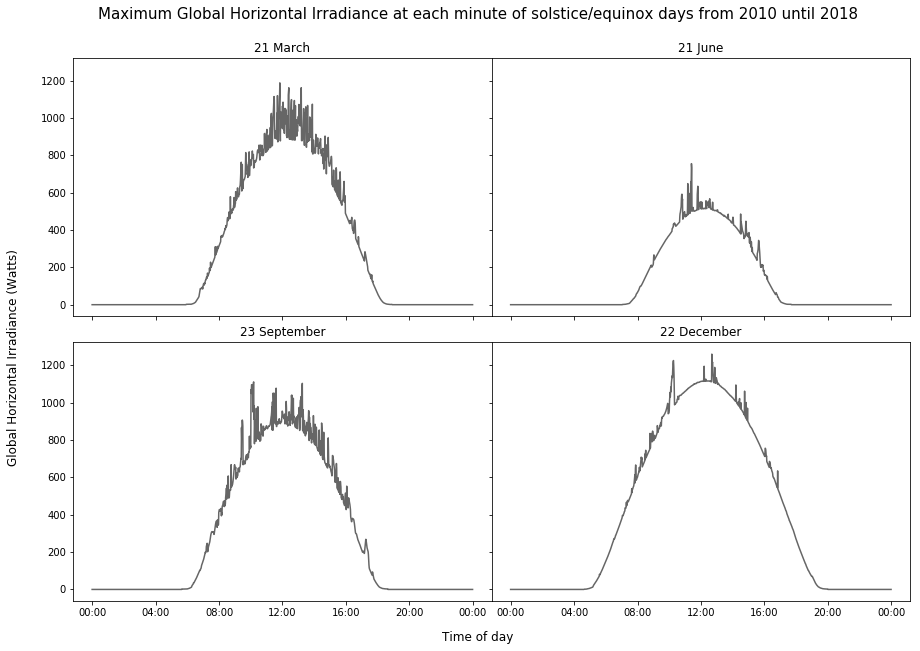

In [44]:
solstice_equinox_dates = {'21 March':(3,21), 
                          '21 June':(6,21), 
                          '23 September':(9,23), 
                          '22 December':(12,22)}

fig, axes = plt.subplots(2,2, sharex=True, sharey=True, figsize=(15,10))
axes = axes.ravel()

hrs = mdates.HourLocator(interval = 4)
h_fmt = mdates.DateFormatter("%H:%M")

for i, (k,v) in enumerate(solstice_equinox_dates.items()):
    axes[i].plot(PV_clear_sky.xs(v,axis=0).index.map(add_date),PV_clear_sky.xs(v, axis=0).GHI, '0.4')
    axes[i].set_title(k)
    axes[i].xaxis.set_major_locator(hrs)
    axes[i].xaxis.set_major_formatter(h_fmt)
 
fig.text(0.5, 0.07, 'Time of day', fontsize=12, ha='center')
fig.text(0.07, 0.6, 'Global Horizontal Irradiance (Watts)', fontsize=12, ha='center', rotation='vertical')
fig.subplots_adjust(wspace=0,hspace=0.1)
fig.suptitle(str('Maximum Global Horizontal Irradiance at each minute of solstice/equinox days from ' \
                 + str(from_year) + ' until ' + str(to_year+1)), fontsize=15, y=0.95);

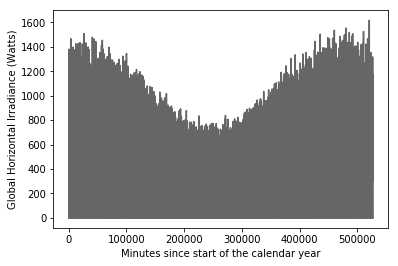

In [45]:
plt.plot(PV_clear_sky.iloc[:,:]['GHI'].values, '0.4')
plt.xlabel('Minutes since start of the calendar year')
plt.ylabel('Global Horizontal Irradiance (Watts)')
plt.show;

### Investigate the Power Spectrum

In [46]:
def power_spectrum(dat,freq_num):
    return(Null)
    # for each frequency to be graphed
        # set s1, s2 and s0 to be zero
        # for each timestamp
            # set s0 to be the timestamp
        # Set the first frequency to be zero
        # Set the first frequency to be the timestamp divided by the number of values
        # for each frequency except the first
            # power
            

In [47]:
# Not yet complete (used John's Excel version instead)

### Build a Fourier Model

In [48]:
# Set frequencies
daily = 2*np.pi/60/24

freqs = {
    'daily':daily,
    'yearly':(1/365.24219)*daily,
    'half_yearly':(1/365.24219*2)*daily
        }

Creates a matrix where each column is the individual effect of the sine and cosine for each given frequency at each given timestamp. The row sum is the cumulative effect of all frequencies at each timestamp.

In [49]:
def fourier_terms(time_stamp,**args):
    M = np.empty(shape=(len(time_stamp),len(args)*2))
    freq_names = []
    for i, (k,v) in enumerate(args.items()):
        M[:,2*i  ] = np.cos(v * time_stamp)
        M[:,2*i+1] = np.sin(v * time_stamp)
        freq_names.append(k + '_cos')
        freq_names.append(k + '_sin')
    return([M,freq_names])

Apply to our timestamps, creating a set of predictor variables in the `PV_clear_sky` dataframe.

In [50]:
X,X_names = fourier_terms(PV_clear_sky.t,**freqs)

In [51]:
PV_clear_sky = pd.concat([PV_clear_sky,
                          pd.DataFrame(X, columns=X_names, index=PV_clear_sky.index)],
                         axis=1)

A more natural fit, with fewer parameters, should be possible if the sine/cosine waves in the fitted Fourier model are permitted to go negative at night time. This is achieved by censoring those observed values at zero, i.e. changing them to be missing in the training data.

These values (and timestamps) are then dropped from the training data. First, the index is replaced with 2016's (a leap year, with all possible month_day tuples) so that dropped timestamps can be easily replaced later.

In [52]:
PV_clear_sky.GHI.replace([0], np.nan, inplace=True)

In [53]:
train = PV_clear_sky.copy()
train.index = pd.date_range(start='1/1/2016 00:00:00', end='31/12/2016 23:59:00', freq='T')
train.GHI.replace([0], np.NaN, inplace=True)
train = train.dropna()

Fit a multiple linear regression model

In [54]:
PV_clear_sky[X_names].head()

daily_cos  daily_sin  yearly_cos  yearly_sin  \
month_day time_of_day                                                 
(1, 1)    00:00:00      0.999990   0.004363         1.0    0.000012   
          00:01:00      0.999962   0.008727         1.0    0.000024   
          00:02:00      0.999914   0.013090         1.0    0.000036   
          00:03:00      0.999848   0.017452         1.0    0.000048   
          00:04:00      0.999762   0.021815         1.0    0.000060   

                       half_yearly_cos  half_yearly_sin  
month_day time_of_day                                    
(1, 1)    00:00:00                 1.0         0.000024  
          00:01:00                 1.0         0.000048  
          00:02:00                 1.0         0.000072  
          00:03:00                 1.0         0.000096  
          00:04:00                 1.0         0.000119

In [55]:
mod = sm.OLS(train['GHI'], sm.add_constant(train[X_names]))
res = mod.fit()

In [56]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    GHI   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                 1.341e+06
Date:                Sat, 29 Jun 2019   Prob (F-statistic):               0.00
Time:                        20:33:28   Log-Likelihood:            -1.5785e+06
No. Observations:              282423   AIC:                         3.157e+06
Df Residuals:                  282416   BIC:                         3.157e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -20.1731      0.233    -

Apply the model to our timestamps to get the predictions, then set all predictions that are negative to be zero.

In [57]:
PV_clear_sky['pred'] = (res.params[1:] * PV_clear_sky[X_names]).sum(axis=1) + res.params.const
PV_clear_sky.loc[PV_clear_sky['pred'] < 0,['pred']] = 0

### Fit to the 15$^{th}$ percentile of the maximum values using quantile regression.

In [58]:
expression = str('GHI ~ ' + ' + '.join(X_names))
expression

'GHI ~ daily_cos + daily_sin + yearly_cos + yearly_sin + half_yearly_cos + half_yearly_sin'

In [59]:
mod_Q15 = smf.quantreg(expression, PV_clear_sky)

In [60]:
res_Q15 = mod_Q15.fit(q=0.15)
print(res_Q15.summary())

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


                         QuantReg Regression Results                          
Dep. Variable:                    GHI   Pseudo R-squared:               0.8363
Model:                       QuantReg   Bandwidth:                       3.466
Method:                 Least Squares   Sparsity:                        177.9
Date:                Sat, 29 Jun 2019   No. Observations:               282423
Time:                        20:39:13   Df Residuals:                   282416
                                        Df Model:                            6
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -90.8196      0.191   -475.949      0.000     -91.194     -90.446
daily_cos        -916.3789      0.259  -3542.711      0.000    -916.886    -915.872
daily_sin         -77.7882      0.176   -441.918      0.000     -78.133     -77.443
yearly_cos        272.0464 

Create predictions and set all negative predictions to be zero.

In [61]:
PV_clear_sky['pred_Q15'] = (res_Q15.params[1:] * PV_clear_sky[X_names]).sum(axis=1) + res_Q15.params.Intercept
PV_clear_sky.loc[PV_clear_sky['pred_Q15'] < 0,['pred_Q15']] = 0

### Compare model predictions to observed values

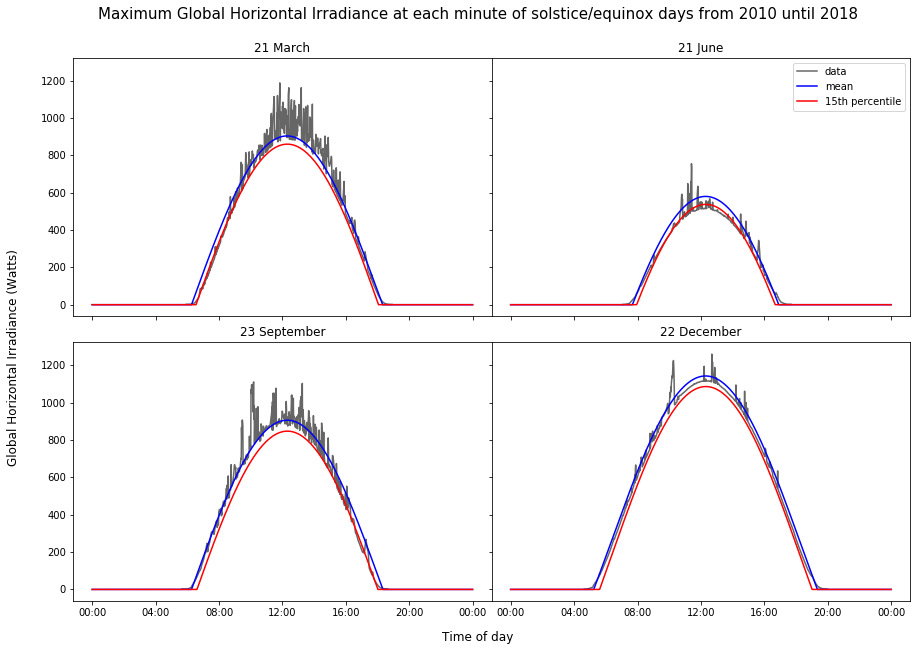

In [62]:
solstice_equinox_dates = {'21 March':(3,21), 
                          '21 June':(6,21), 
                          '23 September':(9,23), 
                          '22 December':(12,22)}

fig, axes = plt.subplots(2,2, sharex=True, sharey=True, figsize=(15,10))
axes = axes.ravel()

hrs = mdates.HourLocator(interval = 4)
h_fmt = mdates.DateFormatter("%H:%M")

for i, (k,v) in enumerate(solstice_equinox_dates.items()):
    axes[i].plot(PV_clear_sky.xs(v,axis=0).index.map(add_date),PV_clear_sky.xs(v, axis=0).GHI, '0.4', label='data')
    axes[i].plot(PV_clear_sky.xs(v,axis=0).index.map(add_date),PV_clear_sky.xs(v, axis=0).pred, 'b-', label='mean')
    axes[i].plot(PV_clear_sky.xs(v,axis=0).index.map(add_date),PV_clear_sky.xs(v, axis=0).pred_Q15, 'r-', label='15th percentile')
    axes[i].set_title(k)   
    axes[i].xaxis.set_major_locator(hrs)
    axes[i].xaxis.set_major_formatter(h_fmt)

axes[1].legend(loc=0)
fig.text(0.5, 0.07, 'Time of day', fontsize=12, ha='center')
fig.text(0.07, 0.6, 'Global Horizontal Irradiance (Watts)', fontsize=12, ha='center', rotation='vertical')
fig.subplots_adjust(wspace=0,hspace=0.1)
fig.suptitle(str('Maximum Global Horizontal Irradiance at each minute of solstice/equinox days from ' \
                 + str(from_year) + ' until ' + str(to_year+1)), fontsize=15, y=0.95);

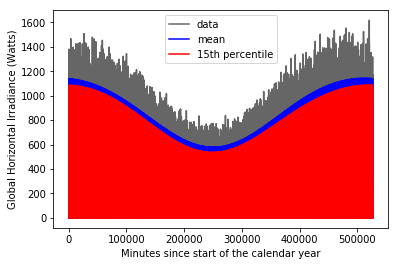

In [63]:
plt.plot(PV_clear_sky.iloc[:,:]['GHI'].values, '0.4', label='data')
plt.plot(PV_clear_sky.iloc[:,:]['pred'].values, 'b-', label='mean')
plt.plot(PV_clear_sky.iloc[:,:]['pred_Q15'].values, 'r-', label='15th percentile')
plt.xlabel('Minutes since start of the calendar year')
plt.ylabel('Global Horizontal Irradiance (Watts)')
plt.legend(loc=0)
plt.show;

### Apply clear sky model to normalise data

Create a variable `t` which indicates the number of minutes since the start of each year, consistent with how the clear sky, Fourier-based model is trained.

In [64]:
PV['t'] = PV.groupby(['year']).cumcount() + 1

In [65]:
X,X_names = fourier_terms(PV.t,**freqs)
#X = pd.DataFrame(X, columns=X_names, index=PV.index)

PV = pd.concat([PV, pd.DataFrame(X, columns=X_names, index=PV.index)], axis=1)

In [66]:
PV.head()

,mean_dir_horiz,mean_diffuse,zenith_dist,GHI,year,month_day,time_of_day,t,daily_cos,daily_sin,yearly_cos,yearly_sin,half_yearly_cos,half_yearly_sin
date_time,,,,,,,,,,,,,,
2010-01-01 00:00:00,0.0,0.0,0.0,0.0,2010,"(1, 1)",00:00:00,1,0.999990,0.004363,1.0,0.000012,1.0,0.000024
2010-01-01 00:01:00,0.0,0.0,0.0,0.0,2010,"(1, 1)",00:01:00,2,0.999962,0.008727,1.0,0.000024,1.0,0.000048
2010-01-01 00:02:00,0.0,0.0,0.0,0.0,2010,"(1, 1)",00:02:00,3,0.999914,0.013090,1.0,0.000036,1.0,0.000072
2010-01-01 00:03:00,0.0,0.0,0.0,0.0,2010,"(1, 1)",00:03:00,4,0.999848,0.017452,1.0,0.000048,1.0,0.000096
2010-01-01 00:04:00,0.0,0.0,0.0,0.0,2010,"(1, 1)",00:04:00,5,0.999762,0.021815,1.0,0.000060,1.0,0.000119


Create clear sky radiation predictions using both regression to the:

* mean (`pred`), and; 
* 15$^{th}$ percentile (`pred_Q15`);

of the maximum of every minute in each of the years.

In [67]:
# Mean
PV['pred'] = (res.params[1:] * PV[X_names]).sum(axis=1) + res.params.const
PV.loc[PV['pred'] < 0,['pred']] = 0

# 15th percentile
PV['pred_Q15'] = (res_Q15.params[1:] * PV[X_names]).sum(axis=1) + res_Q15.params.Intercept
PV.loc[PV['pred_Q15'] < 0,['pred_Q15']] = 0

In [68]:
PV.head()

,mean_dir_horiz,mean_diffuse,zenith_dist,GHI,year,month_day,time_of_day,t,daily_cos,daily_sin,yearly_cos,yearly_sin,half_yearly_cos,half_yearly_sin,pred,pred_Q15
date_time,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,0.0,0.0,0.0,0.0,2010,"(1, 1)",00:00:00,1,0.999990,0.004363,1.0,0.000012,1.0,0.000024,0.0,0.0
2010-01-01 00:01:00,0.0,0.0,0.0,0.0,2010,"(1, 1)",00:01:00,2,0.999962,0.008727,1.0,0.000024,1.0,0.000048,0.0,0.0
2010-01-01 00:02:00,0.0,0.0,0.0,0.0,2010,"(1, 1)",00:02:00,3,0.999914,0.013090,1.0,0.000036,1.0,0.000072,0.0,0.0
2010-01-01 00:03:00,0.0,0.0,0.0,0.0,2010,"(1, 1)",00:03:00,4,0.999848,0.017452,1.0,0.000048,1.0,0.000096,0.0,0.0
2010-01-01 00:04:00,0.0,0.0,0.0,0.0,2010,"(1, 1)",00:04:00,5,0.999762,0.021815,1.0,0.000060,1.0,0.000119,0.0,0.0


Check model fit on an actual sunny day

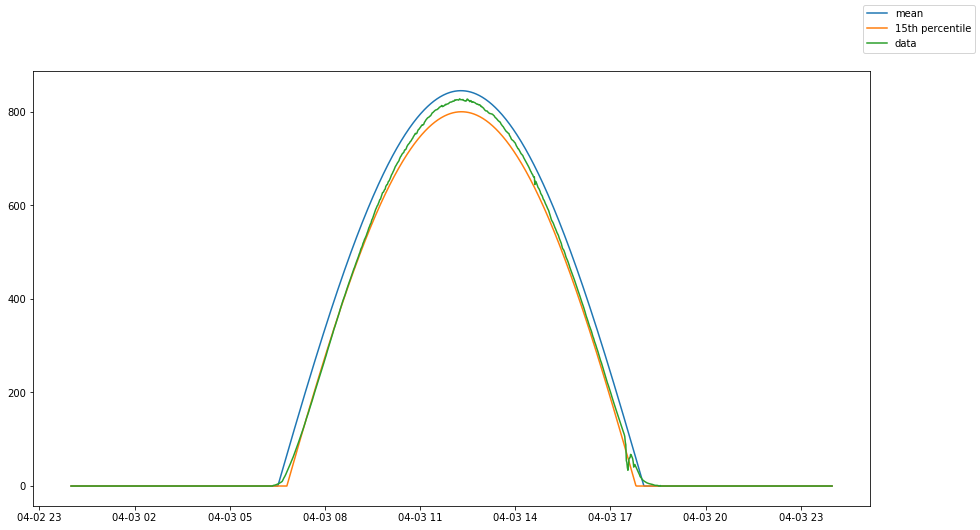

In [83]:
fig,ax = plt.subplots(figsize=(15,8))
ax.plot(PV['2017-4-3'].pred, label="mean")
ax.plot(PV['2017-4-3'].pred_Q15, label="15th percentile")
ax.plot(PV['2017-4-3'].GHI, label="data");
fig.legend()

The next step is to create a 'normalised' solar power variable, being:

\begin{equation}
\text{normalised solar power} = \frac{\text{observed GHI}}{\text{predicted clear sky GHI}}
\end{equation}

Intuitively, this measure describes on a scale of 0 to 1 how sunny it is over a given minute.

Near sunrise and sunset, the calculated normalised solar power can be a division by zero, infinity or a very large number. This is because one of observed GHI or predicted clear sky GHI is very small relative to the other. At these points, the predictions are small not contributing significantly to the overall estimate of solar power generation and can be ignored (set to zero). 

These tails (sunrise and sunset) can be targeted by setting a threshold for the `zenith_dist` variable, indicating the angular distance from directly overhead, ie. 90$^{\circ}$ - solar altitude.

In our case, we will only calculate normalised GHI when the `zenith_dist` is below 80$^{\circ}$.

In [70]:
PV['norm'] = np.nan
PV['norm_Q15'] = np.nan

In [82]:
PV.to_csv('../Relevant data/Capstone/solar/PV_norm.csv')

In [71]:
PV.loc[PV['zenith_dist'] < 80,'norm'] = PV.GHI / PV.pred
PV.loc[PV['zenith_dist'] < 80,'norm_Q15'] = PV.GHI / PV.pred_Q15

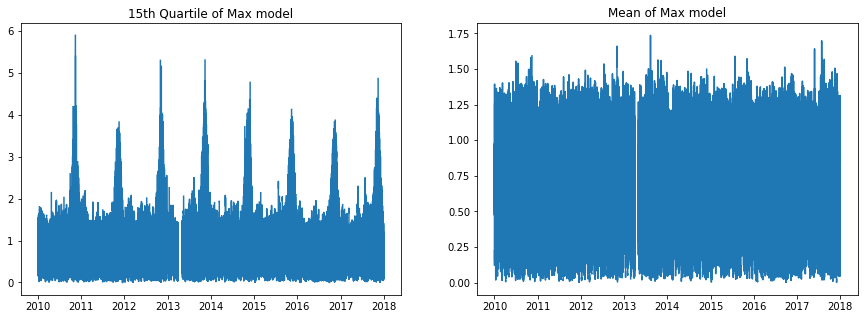

In [72]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(PV.norm_Q15)
ax1.set_title('15th Quartile of Max model')
ax2.plot(PV.norm)
ax2.set_title('Mean of Max model');

Something needs investigating in late 2003.  What if these outliers are excluded?

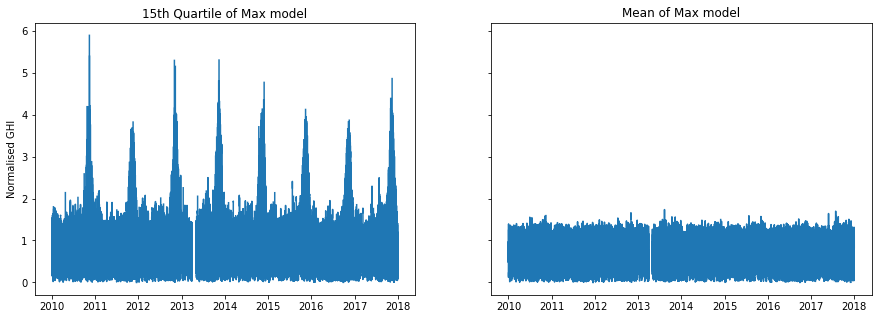

In [73]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5), sharey=True)
ax1.plot(PV.norm_Q15['2004':])
ax1.set_ylabel('Normalised GHI')
ax1.set_title('15th Quartile of Max model')
ax2.plot(PV.norm['2004':])
ax2.set_title('Mean of Max model');

In [74]:
PV.norm.describe()

count    1.717446e+06
mean     7.016890e-01
std      2.918713e-01
min      4.067497e-04
25%      4.425544e-01
50%      8.264240e-01
75%      9.433166e-01
max      1.736938e+00
Name: norm, dtype: float64

In [75]:
PV.norm_Q15.describe()

count    1.717446e+06
mean     7.927830e-01
std      3.372661e-01
min      5.799040e-04
25%      5.042780e-01
50%      9.391352e-01
75%      1.024266e+00
max      5.888592e+00
Name: norm_Q15, dtype: float64

The 'inf' values need further investigating.

Following is the normalised GHI over a partly cloudy day, rather than many years.

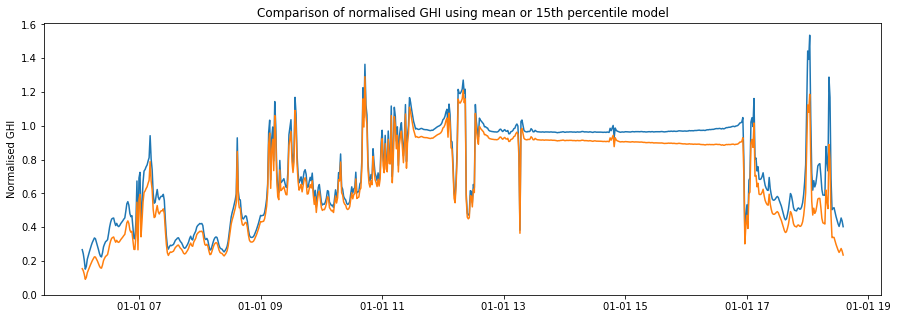

In [76]:
fig, ax1 = plt.subplots(1,1,figsize=(15,5), sharey=True)
ax1.plot(PV.norm_Q15['2017-1-1'])
ax1.set_ylabel('Normalised GHI')
ax1.set_title('15th Quartile of Max model')
ax1.plot(PV.norm['2017-1-1']);
ax1.set_title('Comparison of normalised GHI using mean or 15th percentile model')
ax1.set_ylim(0);
fig.subplots_adjust(wspace=0);

In comparison to the observed GHI and prediction on the same day

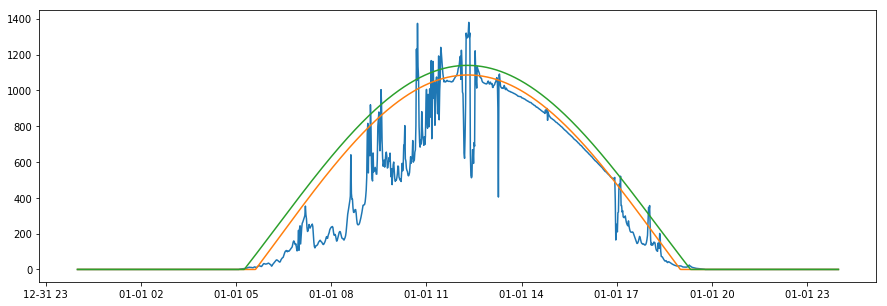

In [77]:
fig, ax1 = plt.subplots(1,1,figsize=(15,5), sharey=True)
ax1.plot(PV.GHI['2017-1-1'])
ax1.plot(PV.pred_Q15['2017-1-1'])
ax1.plot(PV.pred['2017-1-1']);

# It would be helpful to insert bands/lines showing range of where zenith_dist < 80 degrees  

Now a sunny day

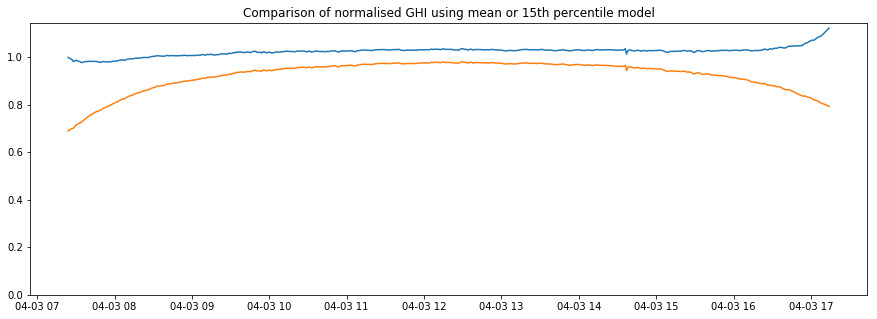

In [78]:
fig, ax1 = plt.subplots(1,1,figsize=(15,5), sharey=True)
ax1.plot(PV.norm_Q15['2017-4-3'])
ax1.plot(PV.norm['2017-4-3'])
ax1.set_title('Comparison of normalised GHI using mean or 15th percentile model')
ax1.set_ylim(0);

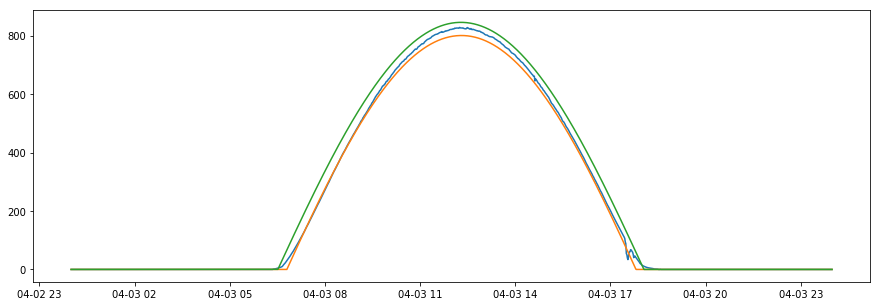

In [79]:
fig, ax1 = plt.subplots(1,1,figsize=(15,5), sharey=True)
ax1.plot(PV.GHI['2017-4-3'])
ax1.plot(PV.pred_Q15['2017-4-3'])
ax1.plot(PV.pred['2017-4-3']);

The 15$^{th}$ percentile model provides a better overall fit with a straighter line in sunny days but has more of a problem with "horns" at the sunrise/sunset tails.